In [1]:
import librosa
import numpy as np
from moviepy.editor import VideoClip, AudioFileClip
from moviepy.video.io.bindings import mplfig_to_npimage

In [2]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [3]:
import time

In [4]:
import sys

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
sys.path.append('..')
sys.path.append('..\\tools\\visualize_app')

In [7]:
from plotter import SequenceDataGen

In [8]:
from matplotlib import pyplot as plt

In [9]:
start = [
    [45, -20, 20],   # 'rightMiddle'
    [45, 110, 20],   # 'rightFront'
    [-45, 110, 20],  # 'leftFront'
    [-45, -20, 20],  # 'leftMiddle'
    [0, -20, 20],    # 'leftBack'
    [0, -20, 20]     # 'rightBack'
]
end = [
    [45, -20, 20],
    [0, 110, -80],
    [-90, 110, -80],
    [-45, -20, 20],
    [0, -20, 20],
    [0, -20, 20]
]
new_end = [
    [45, -20, 20],
    [90, 110, -80],
    [0, 110, -80],
    [-45, -20, 20],
    [0, -20, 20],
    [0, -20, 20]
]

In [10]:
###

In [11]:
def read_wav(path):
    signal, sr = librosa.load(path)
    time = np.linspace(0, 1 / sr * len(signal), num=len(signal))
    return {'signal': signal, 'time': time, 'sr': sr}


def extract_beats(audio_dict):
    tempo, beats = librosa.beat.beat_track(y=audio_dict['signal'], sr=audio_dict['sr'])
    beats_time = librosa.frames_to_time(beats, sr=audio_dict['sr'])
    return beats_time

In [12]:
audio_d = read_wav('test.wav')

In [ ]:
###

In [13]:
audio_len = len(audio_d['signal'])/audio_d['sr']

In [14]:
beats = extract_beats(audio_d)

In [15]:
beats

array([0.60371882, 1.11455782, 1.64861678, 2.15945578, 2.69351474,
       3.20435374, 3.7384127 , 4.2492517 ])

In [16]:
beats = np.append([0], beats)

In [17]:
### generate sequence

In [18]:
fps = 40
vid_dt = 1./fps

In [19]:
s = SequenceDataGen()

In [20]:
for ix in range( (len(beats)-1)//2 ):
    n_frames = int(np.floor((beats[2*ix+1]-beats[2*ix])/vid_dt))
    s.get_sequence(start_pose=start, end_pose=end, n_frames=n_frames, reverse=False)
    print(n_frames)
    n_frames = int(np.floor((beats[2*ix+2]-beats[2*ix+1])/vid_dt))
    s.get_sequence(start_pose=end, end_pose=start, n_frames=n_frames, reverse=False)
    print(n_frames)

24
20
21
20
21
20
21
20


In [21]:
## fill missing

In [22]:
n_fr_miss = int((audio_len - len(s.leg_lines)/fps)*fps)

In [23]:
s.get_sequence(start_pose=start, end_pose=start, n_frames=n_fr_miss, reverse=False)

In [24]:
video_frames = len(s.leg_lines)
video_dur = len(s.leg_lines)/fps

In [25]:
###

In [26]:
def draw_hexapod(fig, ax, t, leg_lines, body_poly, body_vertices):
    
    ax.clear()
    i = int(t/vid_dt)
    # plt.cla()
    # plt.gcf().canvas.mpl_connect('key_release_event',
    #                              lambda event: [exit(0) if event.key == 'escape' else None])

    # plot base stand polygon
    # base_poly = Poly3DCollection([stand_pts], alpha=0.5)
    # ax.add_collection3d(base_poly)

    # plot hexapod body polygon
    poly = Poly3DCollection([body_poly[i]], alpha=0.5)
    ax.add_collection3d(poly)
    # plot poly vertices
    ax.plot(body_vertices[i][0], body_vertices[i][1], body_vertices[i][2])
    ax.scatter(body_vertices[i][0], body_vertices[i][1], body_vertices[i][2])
    # plot legs
    for leg in leg_lines[i]:
        ax.plot(leg[0], leg[1], leg[2])
        ax.scatter(leg[0], leg[1], leg[2])

    # remove axis info
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['tick']['inward_factor'] = 0.0
        axis._axinfo['tick']['outward_factor'] = 0.0

    # setup current frame settings
    ax.set_xlim3d([-400,400])
    ax.set_ylim3d([-400,400])
    ax.set_zlim3d([0,300])
    # ax.margins(x=0, y=-0.25, z=50)
    # ax.set_aspect('equal')
    ax.view_init(elev=30, azim=75)


        # plt.pause(0.1)
    return mplfig_to_npimage(fig)


In [ ]:
###

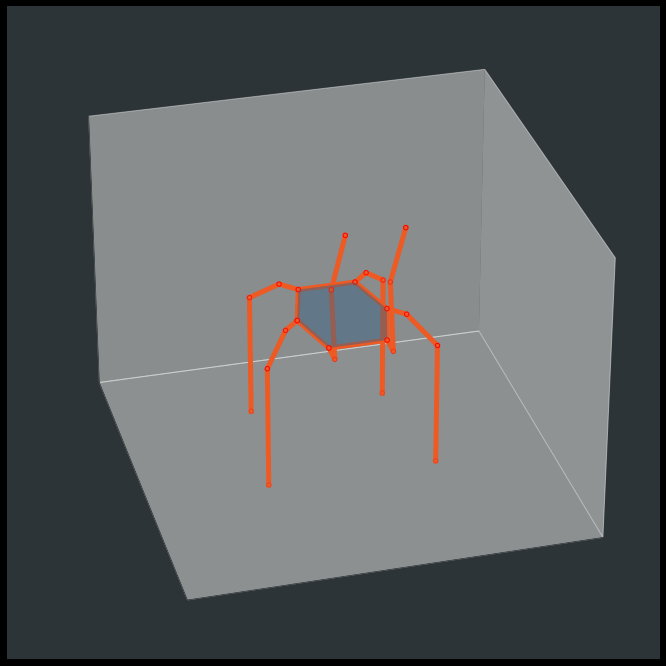

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
video = VideoClip(lambda x: draw_hexapod(fig, ax, x, s.leg_lines, s.body_poly, s.body_vertices), duration=video_dur)

In [28]:
audio = AudioFileClip('test.wav')

In [29]:
final_vid = video.set_audio(audio)

In [30]:
t1 = time.time()
final_vid.write_videofile(fps=fps, codec='libx264', filename='test.mp4')
print(f'Total secs: {time.time()-t1}')

t:   0%|                                                                             | 0/200 [00:00<?, ?it/s, now=None]

Moviepy - Building video test.mp4.
MoviePy - Writing audio in testTEMP_MPY_wvf_snd.mp3
MoviePy - Done.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4
Total secs: 24.31874990463257
